In [10]:
import sys, os

path = "C:\\Users\\gabri\\OneDrive - University of Copenhagen\\Escritorio\\university_of_copenhagen\\ku\\block_6\\probabilistic_machine_learning\\final_assignment\\exercise_1.ipynb"

os.chdir(path)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\gabri\\OneDrive - University of Copenhagen\\Escritorio\\university_of_copenhagen\\ku\\block_6\\probabilistic_machine_learning\\final_assignment\\exercise_1.ipynb'

In [8]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from VAE import VAEConfig, train_vae

# -------------------------
# Device
# -------------------------
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

ModuleNotFoundError: No module named 'VAE'

# Data

In [ ]:
batch_size = 128
val_split = 0.1
num_workers = 2

transform = transforms.ToTensor()  # required for BCE loss in vae.py

dataset_full = datasets.MNIST("./mnist_data", download=True, train=True, transform=transform)
n_val = int(len(dataset_full) * val_split)
n_train = len(dataset_full) - n_val
dataset_train, dataset_val = random_split(dataset_full, [n_train, n_val])

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=True)

NameError: name 'transforms' is not defined

# Beta-VAE 

In [ ]:
# -------------------------
# Experiment grid
# -------------------------
latent_dims = [2, 16]
betas = [0.01, 0.1, 1.0]

# Training knobs (shared)
epochs = 15
lr = 2e-3
seed = 42

run_root = "./runs_vae"  # parent folder

# optional: keep a summary list
runs_summary = []

for zdim in latent_dims:
    for beta in betas:
        run_name = f"mnist_betaVAE_z{zdim}_beta{beta:g}_e{epochs}_lr{lr:g}_seed{seed}"
        print("\n" + "="*90)
        print("RUN:", run_name)
        print("="*90)

        cfg = VAEConfig(
            latent_dim=zdim,
            beta=float(beta),
            epochs=epochs,
            lr=lr,
            seed=seed,
            run_root=run_root,
            run_name=run_name,        # ensures separate folder per config
            save_best_only=True,

            # plot params
            max_images_plot=16,
            prior_n_plot=25,
            latent_grid_size=20,
            latent_grid_lim=3.0,
            latent_scatter_max_points=5000,
        )

        model, history, run_dir = train_vae(cfg, dataloader_train, dataloader_val, device)

        runs_summary.append({
            "run_name": run_name,
            "run_dir": run_dir,
            "latent_dim": zdim,
            "beta": beta,
            "final_val_loss": history["val_loss"][-1],
            "final_val_recon": history["val_recon"][-1],
            "final_val_kl": history["val_kl"][-1],
        })

print("\nAll runs finished.")


In [ ]:
transform = transforms.ToTensor()

dataset_full = datasets.MNIST(cfg.data_dir, download=True, train=True, transform=transform)
n_val = int(len(dataset_full) * cfg.val_split)
n_train = len(dataset_full) - n_val
dataset_train, dataset_val = random_split(dataset_full, [n_train, n_val])

dataloader_train = DataLoader(dataset_train, batch_size=cfg.batch_size, shuffle=True,
                              num_workers=cfg.num_workers, pin_memory=True)
dataloader_val = DataLoader(dataset_val, batch_size=cfg.batch_size, shuffle=False,
                            num_workers=cfg.num_workers, pin_memory=True)

# Your lines (already integrated above conceptually):
device = cfg.device

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.62MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 129kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.25MB/s]


# $\beta$ - VAE

## Latent DDPM

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        # t: [B] int64
        half = self.dim // 2
        freqs = torch.exp(
            -math.log(10000) * torch.arange(0, half, device=t.device).float() / (half - 1)
        )
        args = t.float().unsqueeze(1) * freqs.unsqueeze(0)  # [B, half]
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=1)  # [B, dim]
        return emb


class LatentDenoiser(nn.Module):
    def __init__(self, latent_dim, time_dim=128, hidden=256, depth=3):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalTimeEmbedding(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.SiLU(),
        )

        layers = []
        in_dim = latent_dim + time_dim
        for _ in range(depth - 1):
            layers += [nn.Linear(in_dim, hidden), nn.SiLU()]
            in_dim = hidden
        layers += [nn.Linear(in_dim, latent_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, z_t, t):
        # z_t: [B, d], t: [B]
        t_emb = self.time_mlp(t)
        x = torch.cat([z_t, t_emb], dim=1)
        return self.net(x)  # predicted eps


In [ ]:
def cosine_beta_schedule(T, s=0.008):
    steps = T + 1
    x = torch.linspace(0, T, steps)
    acp = torch.cos(((x / T) + s) / (1 + s) * math.pi / 2) ** 2
    acp = acp / acp[0]
    betas = 1 - (acp[1:] / acp[:-1])
    return betas.clamp(1e-4, 0.999)

def extract(a, t, shape):
    # a: [T], t: [B] -> [B, 1, ...] for broadcasting
    out = a.gather(0, t)
    return out.view(t.size(0), *([1] * (len(shape) - 1)))


In [ ]:
class LatentDDPM:
    def __init__(self, denoiser, latent_dim, T=200, device="cuda"):
        self.denoiser = denoiser
        self.latent_dim = latent_dim
        self.T = T
        self.device = device

        betas = cosine_beta_schedule(T).to(device)         # [T]
        alphas = 1.0 - betas                               # [T]
        acp = torch.cumprod(alphas, dim=0)                 # [T]
        acp_prev = torch.cat([torch.ones(1, device=device), acp[:-1]], dim=0)

        self.betas = betas
        self.alphas = alphas
        self.acp = acp
        self.acp_prev = acp_prev

        self.sqrt_acp = torch.sqrt(acp)
        self.sqrt_one_minus_acp = torch.sqrt(1.0 - acp)

        # posterior variance (DDPM)
        self.posterior_var = betas * (1.0 - acp_prev) / (1.0 - acp)

    def q_sample(self, z0, t, eps=None):
        # z_t = sqrt(acp_t) z0 + sqrt(1-acp_t) eps
        if eps is None:
            eps = torch.randn_like(z0)
        return extract(self.sqrt_acp, t, z0.shape) * z0 + extract(self.sqrt_one_minus_acp, t, z0.shape) * eps, eps

    def p_mean(self, z_t, t):
        # mu_theta(z_{t-1} | z_t) using eps prediction
        eps_pred = self.denoiser(z_t, t)
        beta_t = extract(self.betas, t, z_t.shape)
        alpha_t = extract(self.alphas, t, z_t.shape)
        acp_t = extract(self.acp, t, z_t.shape)

        mean = (1.0 / torch.sqrt(alpha_t)) * (z_t - (beta_t / torch.sqrt(1.0 - acp_t)) * eps_pred)
        return mean

    @torch.no_grad()
    def p_sample(self, z_t, t):
        mean = self.p_mean(z_t, t)
        var = extract(self.posterior_var, t, z_t.shape)
        noise = torch.randn_like(z_t)

        # no noise at t=0
        nonzero = (t != 0).float().view(-1, *([1] * (z_t.dim() - 1)))
        return mean + nonzero * torch.sqrt(var) * noise

    @torch.no_grad()
    def sample(self, n):
        z = torch.randn(n, self.latent_dim, device=self.device)  # start from N(0,I)
        for tt in reversed(range(self.T)):
            t = torch.full((n,), tt, device=self.device, dtype=torch.long)
            z = self.p_sample(z, t)
        return z

    def training_loss(self, z0):
        B = z0.size(0)
        t = torch.randint(0, self.T, (B,), device=z0.device, dtype=torch.long)
        z_t, eps = self.q_sample(z0, t)
        eps_pred = self.denoiser(z_t, t)
        return F.mse_loss(eps_pred, eps)


In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def train_diffusion(latent_path, vae, device,
                    T=200, epochs=20, batch_size=512, lr=2e-4,
                    hidden=256, depth=3):
    # latent dataset
    ds = LatentDataset(latent_path, scaled=True)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=True)

    d = ds.z.size(1)
    denoiser = LatentDenoiser(latent_dim=d, hidden=hidden, depth=depth).to(device)
    ddpm = LatentDDPM(denoiser, latent_dim=d, T=T, device=device)
    opt = torch.optim.Adam(denoiser.parameters(), lr=lr)

    losses = []
    denoiser.train()
    for ep in range(1, epochs + 1):
        running = 0.0
        for z0, _ in dl:
            z0 = z0.to(device)
            opt.zero_grad()
            loss = ddpm.training_loss(z0)
            loss.backward()
            opt.step()
            running += loss.item()

        avg = running / len(dl)
        losses.append(avg)
        print(f"[Diffusion] epoch {ep:03d}/{epochs}  loss={avg:.6f}")

    # plot diffusion loss curve
    plt.figure()
    plt.plot(losses)
    plt.xlabel("epoch")
    plt.ylabel("MSE (eps prediction)")
    plt.title("Latent diffusion training loss")
    plt.show()

    return ddpm, ds  # return dataset too (for mean/std)


In [ ]:
@torch.no_grad()
def generate_images_from_diffusion(ddpm, vae, latent_ds, device, n=25):
    vae.eval()

    # 1) sample in scaled latent space (mean 0 std 1)
    z_scaled = ddpm.sample(n)  # [n, d], on device

    # 2) unscale back to VAE latent space
    mean = latent_ds.mean.to(device)
    std = latent_ds.std.to(device)
    z = z_scaled * std + mean

    # 3) decode to images
    imgs = vae.decode(z).cpu()  # [n,1,28,28]

    # plot
    cols = int(math.sqrt(n))
    rows = int(math.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(1.8*cols, 1.8*rows))
    axes = axes.flatten()
    for i in range(rows*cols):
        axes[i].axis("off")
        if i < n:
            axes[i].imshow(imgs[i,0], cmap="gray")
    plt.suptitle("Generated samples (latent diffusion → VAE decode)")
    plt.tight_layout()
    plt.show()


In [ ]:
@torch.no_grad()
def plot_latent_scatter_2d(latent_ds, ddpm=None, n_samples=2000):
    if latent_ds.z.size(1) != 2:
        print("latent_dim != 2, skipping scatter.")
        return

    z = latent_ds.z  # unscaled stored latents_mu
    y = latent_ds.y

    # subsample
    idx = torch.randperm(z.size(0))[:n_samples]
    z_sub = z[idx]
    y_sub = y[idx]

    plt.figure()
    plt.scatter(z_sub[:,0], z_sub[:,1], s=5, alpha=0.5, c=y_sub, cmap="tab10")
    plt.colorbar()
    plt.title("μ latents (unscaled) colored by label")
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.show()

    # diffusion samples (in scaled space) projected after unscale
    if ddpm is not None:
        z_scaled = ddpm.sample(1000).cpu()
        z_gen = z_scaled * latent_ds.std + latent_ds.mean
        plt.figure()
        plt.scatter(z_gen[:,0], z_gen[:,1], s=5, alpha=0.5)
        plt.title("Diffusion samples in latent space (unscaled)")
        plt.xlabel("z1")
        plt.ylabel("z2")
        plt.show()


In [ ]:
@torch.no_grad()
def plot_latent_grid_decode_2d(vae, latent_ds, device, grid=20, lim=3.0):
    if latent_ds.z.size(1) != 2:
        print("latent_dim != 2, skipping grid decode.")
        return

    vae.eval()
    # We grid in *scaled* space, then unscale, then decode
    xs = torch.linspace(-lim, lim, grid)
    ys = torch.linspace(-lim, lim, grid)

    canvas = torch.zeros(grid*28, grid*28)

    mean = latent_ds.mean.to(device)
    std = latent_ds.std.to(device)

    for i, y in enumerate(ys.flip(0)):
        for j, x in enumerate(xs):
            z_scaled = torch.tensor([[x, y]], device=device)
            z = z_scaled * std + mean
            img = vae.decode(z)[0,0].cpu()
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = img

    plt.figure(figsize=(8,8))
    plt.imshow(canvas, cmap="gray")
    plt.axis("off")
    plt.title("Latent grid decode (scaled grid → unscale → decode)")
    plt.show()


# Train

In [ ]:
def run_epoch(model, loader, optimizer, device, beta, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss, total_recon, total_kl = 0.0, 0.0, 0.0
    n_batches = 0

    for step, (x, _) in enumerate(loader):
        x = x.to(device)

        if train:
            optimizer.zero_grad()

        logits, mu, logvar, z = model(x)
        loss, recon, kl = beta_vae_loss(x, logits, mu, logvar, beta=beta)

        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        total_recon += recon.item()
        total_kl += kl.item()
        n_batches += 1

    return total_loss / n_batches, total_recon / n_batches, total_kl / n_batches


# Training

Epoch 001/15 | train: loss=192.075 recon=191.950 kl=12.467 | val: loss=163.817 recon=163.690 kl=12.659
Epoch 002/15 | train: loss=158.224 recon=158.105 kl=11.867 | val: loss=153.906 recon=153.782 kl=12.422
Epoch 003/15 | train: loss=151.928 recon=151.811 kl=11.735 | val: loss=150.201 recon=150.084 kl=11.748
Epoch 004/15 | train: loss=148.893 recon=148.776 kl=11.681 | val: loss=147.928 recon=147.812 kl=11.526
Epoch 005/15 | train: loss=147.039 recon=146.922 kl=11.622 | val: loss=146.862 recon=146.741 kl=12.122
Epoch 006/15 | train: loss=145.526 recon=145.409 kl=11.684 | val: loss=145.290 recon=145.173 kl=11.626
Epoch 007/15 | train: loss=144.411 recon=144.294 kl=11.729 | val: loss=144.848 recon=144.729 kl=11.950
Epoch 008/15 | train: loss=143.526 recon=143.408 kl=11.888 | val: loss=144.279 recon=144.160 kl=11.873
Epoch 009/15 | train: loss=142.725 recon=142.605 kl=12.023 | val: loss=143.546 recon=143.429 kl=11.723
Epoch 010/15 | train: loss=142.050 recon=141.929 kl=12.138 | val: loss=14

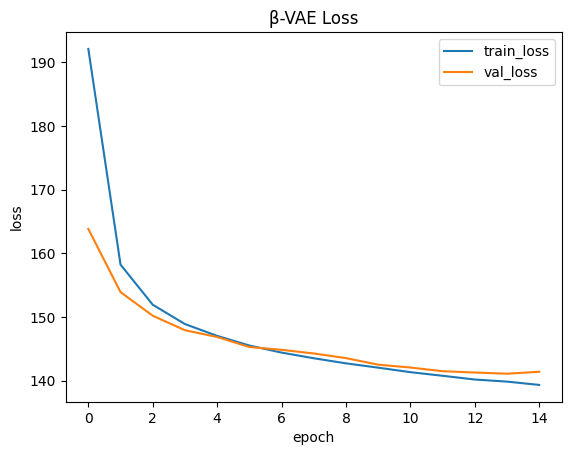

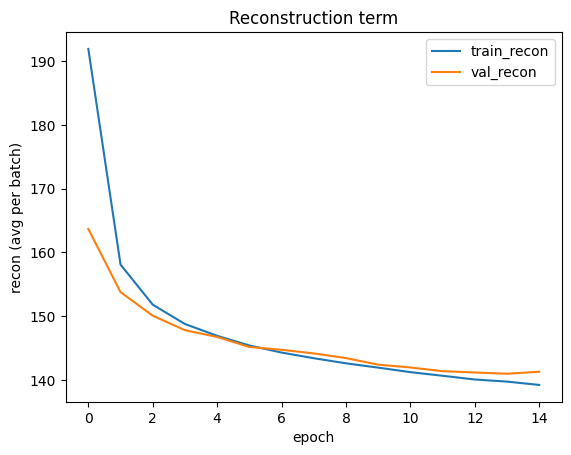

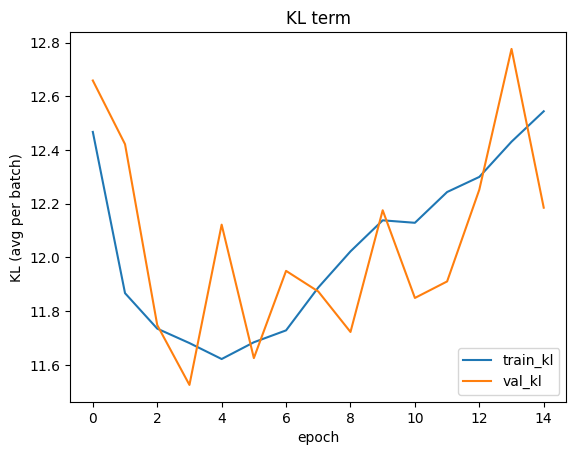

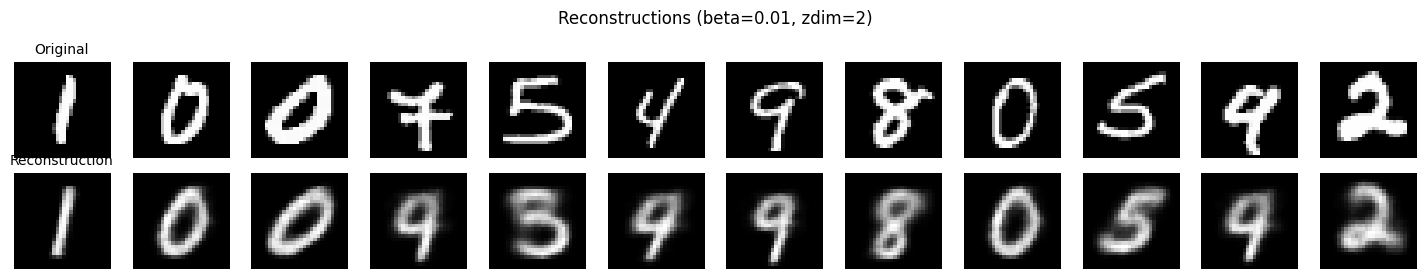

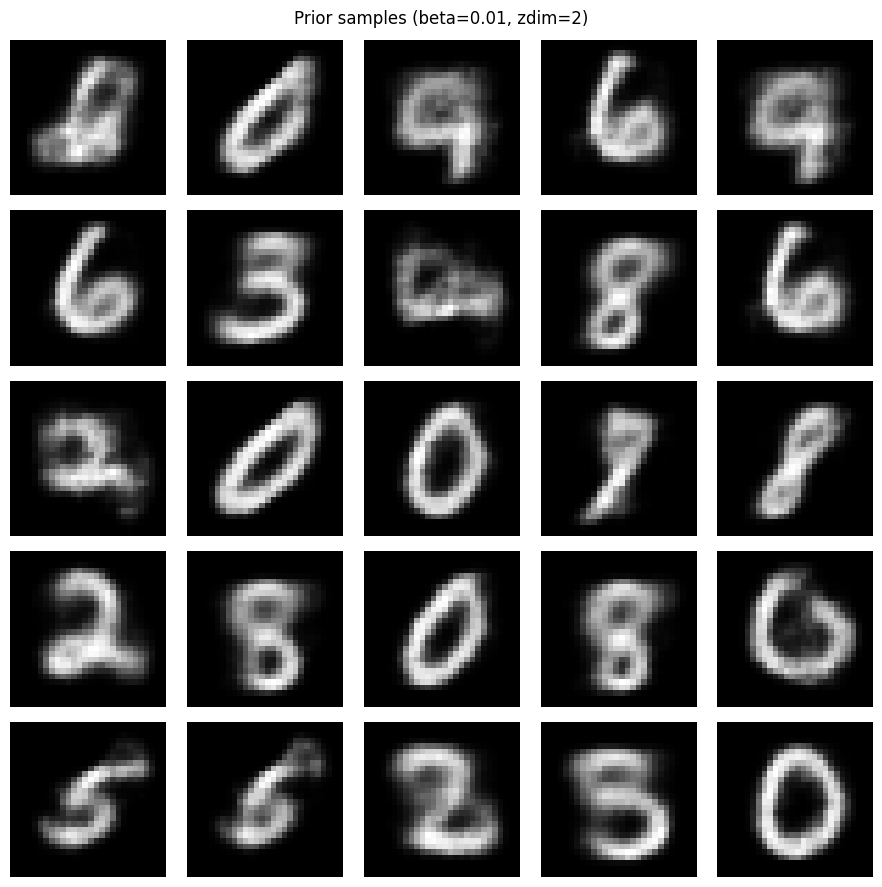

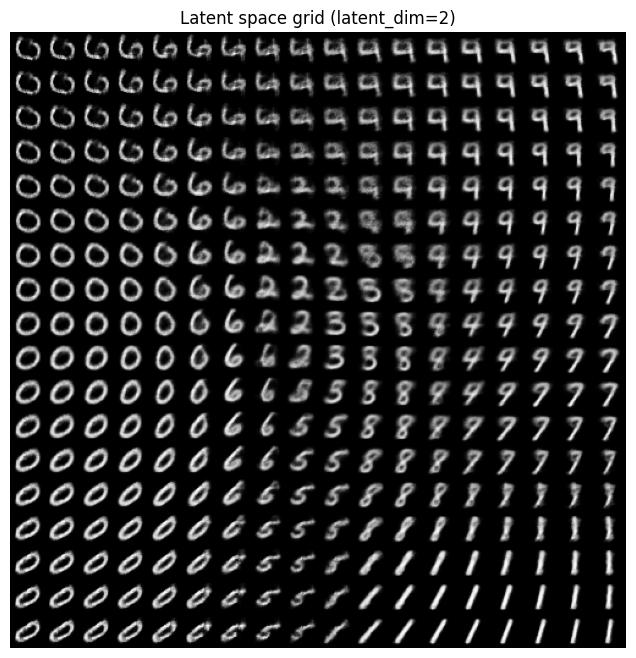

In [ ]:
model = BetaVAE(latent_dim=cfg.latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)

history = {"train_loss": [], "val_loss": [], "train_recon": [], "val_recon": [], "train_kl": [], "val_kl": []}

for epoch in range(1, cfg.epochs + 1):
    train_loss, train_recon, train_kl = run_epoch(
        model, dataloader_train, optimizer, device, beta=cfg.beta, train=True
    )
    val_loss, val_recon, val_kl = run_epoch(
        model, dataloader_val, optimizer, device, beta=cfg.beta, train=False
    )

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_recon"].append(train_recon)
    history["val_recon"].append(val_recon)
    history["train_kl"].append(train_kl)
    history["val_kl"].append(val_kl)

    print(f"Epoch {epoch:03d}/{cfg.epochs} | "
          f"train: loss={train_loss:.3f} recon={train_recon:.3f} kl={train_kl:.3f} | "
          f"val: loss={val_loss:.3f} recon={val_recon:.3f} kl={val_kl:.3f}")

# =========================
# 7) Diagnostics: curves + recon + samples (+latent grid if 2D)
# =========================
plot_curves(history)
show_reconstructions(model, dataloader_val, device, max_images=12, title=f"Reconstructions (beta={cfg.beta}, zdim={cfg.latent_dim})")
show_prior_samples(model, device, n=25, title=f"Prior samples (beta={cfg.beta}, zdim={cfg.latent_dim})")
plot_latent_grid_if_2d(model, device, grid_size=18, lim=3.0)

# 16 latent space

In [ ]:
class Config:
    data_dir = "./mnist_data"
    batch_size = 128
    epochs = 15
    lr = 2e-3
    beta = 0.01            # <-- β in β-VAE (1, 2, 4, 8)
    latent_dim = 16
    seed = 42
    num_workers = 2
    val_split = 0.1
    log_every = 200
    out_dir = "/content/drive/MyDrive/University_of_Copenhagen/block6/PML/final_assignment"
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cfg = Config()

Epoch 001/15 | train: loss=121.353 recon=120.577 kl=77.612 | val: loss=77.310 recon=76.535 kl=77.458
Epoch 002/15 | train: loss=73.793 recon=73.067 kl=72.587 | val: loss=71.785 recon=71.074 kl=71.087
Epoch 003/15 | train: loss=70.176 recon=69.481 kl=69.519 | val: loss=69.476 recon=68.789 kl=68.733
Epoch 004/15 | train: loss=68.546 recon=67.860 kl=68.618 | val: loss=68.310 recon=67.622 kl=68.786
Epoch 005/15 | train: loss=67.407 recon=66.723 kl=68.411 | val: loss=67.511 recon=66.837 kl=67.337
Epoch 006/15 | train: loss=66.666 recon=65.982 kl=68.367 | val: loss=67.108 recon=66.431 kl=67.674
Epoch 007/15 | train: loss=66.146 recon=65.460 kl=68.609 | val: loss=66.613 recon=65.930 kl=68.274
Epoch 008/15 | train: loss=65.733 recon=65.046 kl=68.757 | val: loss=66.256 recon=65.571 kl=68.517
Epoch 009/15 | train: loss=65.323 recon=64.634 kl=68.835 | val: loss=65.995 recon=65.311 kl=68.454
Epoch 010/15 | train: loss=65.066 recon=64.377 kl=68.888 | val: loss=65.463 recon=64.781 kl=68.291
Epoch 01

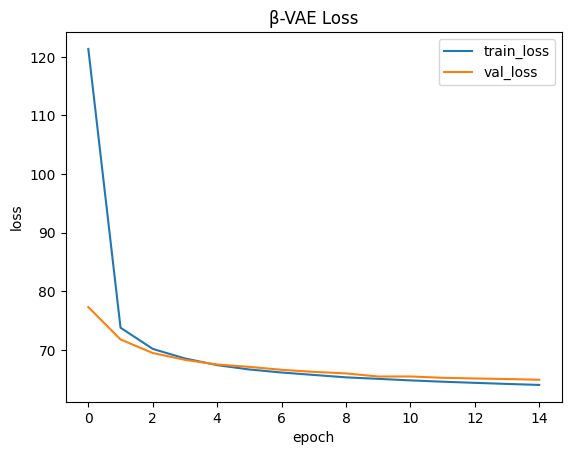

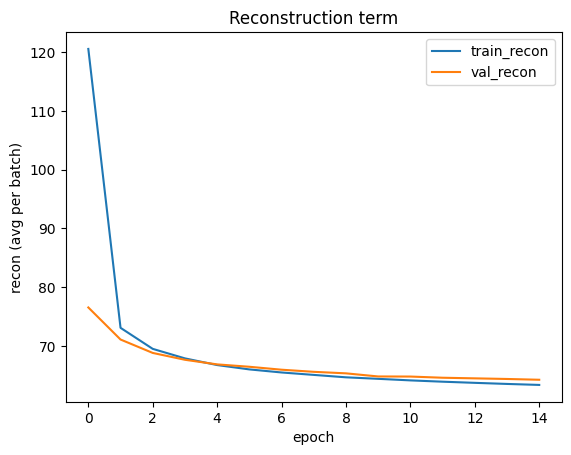

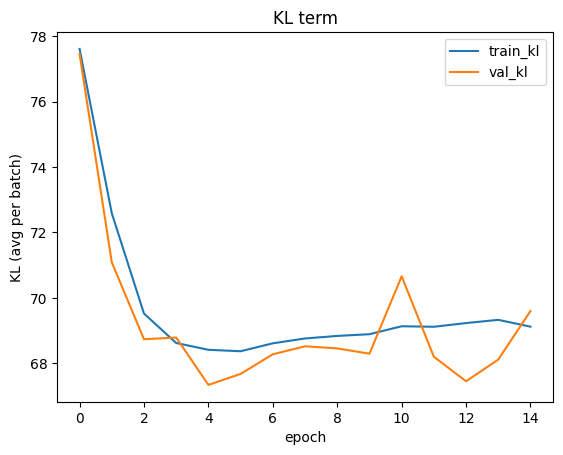

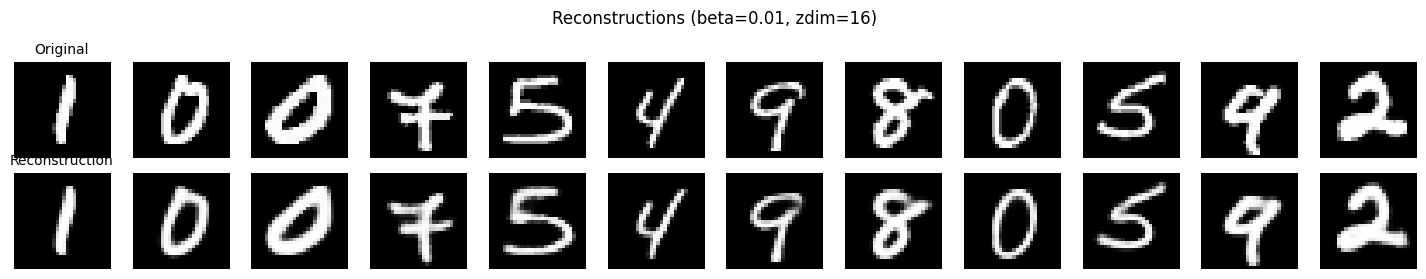

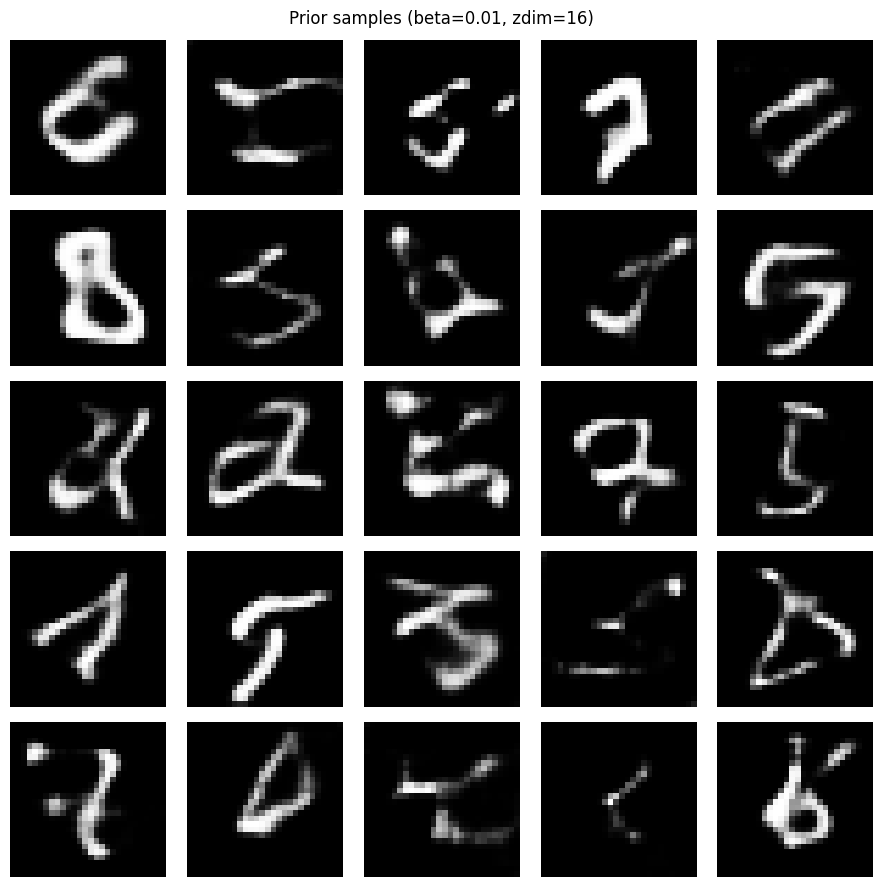

latent_dim != 2, skipping latent grid plot.


In [ ]:
model = BetaVAE(latent_dim=cfg.latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)

history = {"train_loss": [], "val_loss": [], "train_recon": [], "val_recon": [], "train_kl": [], "val_kl": []}

for epoch in range(1, cfg.epochs + 1):
    train_loss, train_recon, train_kl = run_epoch(
        model, dataloader_train, optimizer, device, beta=cfg.beta, train=True
    )
    val_loss, val_recon, val_kl = run_epoch(
        model, dataloader_val, optimizer, device, beta=cfg.beta, train=False
    )

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_recon"].append(train_recon)
    history["val_recon"].append(val_recon)
    history["train_kl"].append(train_kl)
    history["val_kl"].append(val_kl)

    print(f"Epoch {epoch:03d}/{cfg.epochs} | "
          f"train: loss={train_loss:.3f} recon={train_recon:.3f} kl={train_kl:.3f} | "
          f"val: loss={val_loss:.3f} recon={val_recon:.3f} kl={val_kl:.3f}")

# =========================
# 7) Diagnostics: curves + recon + samples (+latent grid if 2D)
# =========================
plot_curves(history)
show_reconstructions(model, dataloader_val, device, max_images=12, title=f"Reconstructions (beta={cfg.beta}, zdim={cfg.latent_dim})")
show_prior_samples(model, device, n=25, title=f"Prior samples (beta={cfg.beta}, zdim={cfg.latent_dim})")
plot_latent_grid_if_2d(model, device, grid_size=18, lim=3.0)

Train diffusion in the latent space

In [ ]:
mnist_train_loader_no_shuffle = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist_data', download=True, train=True, transform=transform),
    batch_size=256, shuffle=False
)
build_latent_dataset(model, mnist_train_loader_no_shuffle, device, "mnist_latents_mu.pt")


Saved latent dataset to: mnist_latents_mu.pt
z shape: torch.Size([60000, 16]) mean/std shape: torch.Size([16]) torch.Size([16])


[Diffusion] epoch 001/20  loss=0.777370
[Diffusion] epoch 002/20  loss=0.484380
[Diffusion] epoch 003/20  loss=0.475509
[Diffusion] epoch 004/20  loss=0.473853
[Diffusion] epoch 005/20  loss=0.471890
[Diffusion] epoch 006/20  loss=0.469650
[Diffusion] epoch 007/20  loss=0.467010
[Diffusion] epoch 008/20  loss=0.462935
[Diffusion] epoch 009/20  loss=0.458508
[Diffusion] epoch 010/20  loss=0.458211
[Diffusion] epoch 011/20  loss=0.456709
[Diffusion] epoch 012/20  loss=0.454413
[Diffusion] epoch 013/20  loss=0.454963
[Diffusion] epoch 014/20  loss=0.449796
[Diffusion] epoch 015/20  loss=0.447465
[Diffusion] epoch 016/20  loss=0.452471
[Diffusion] epoch 017/20  loss=0.449462
[Diffusion] epoch 018/20  loss=0.446615
[Diffusion] epoch 019/20  loss=0.448234
[Diffusion] epoch 020/20  loss=0.444015


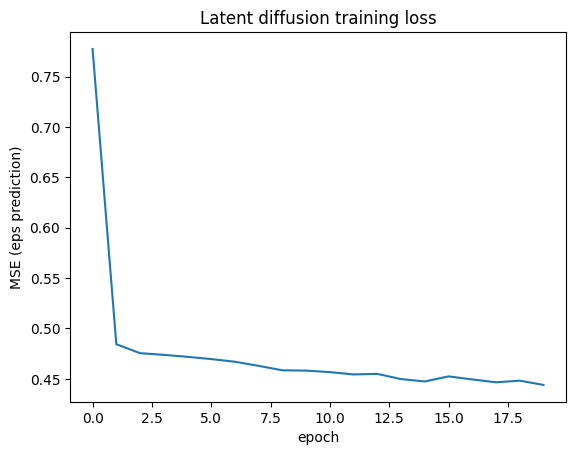

In [ ]:
ddpm, latent_ds = train_diffusion("mnist_latents_mu.pt", model, device, T=200, epochs=20)


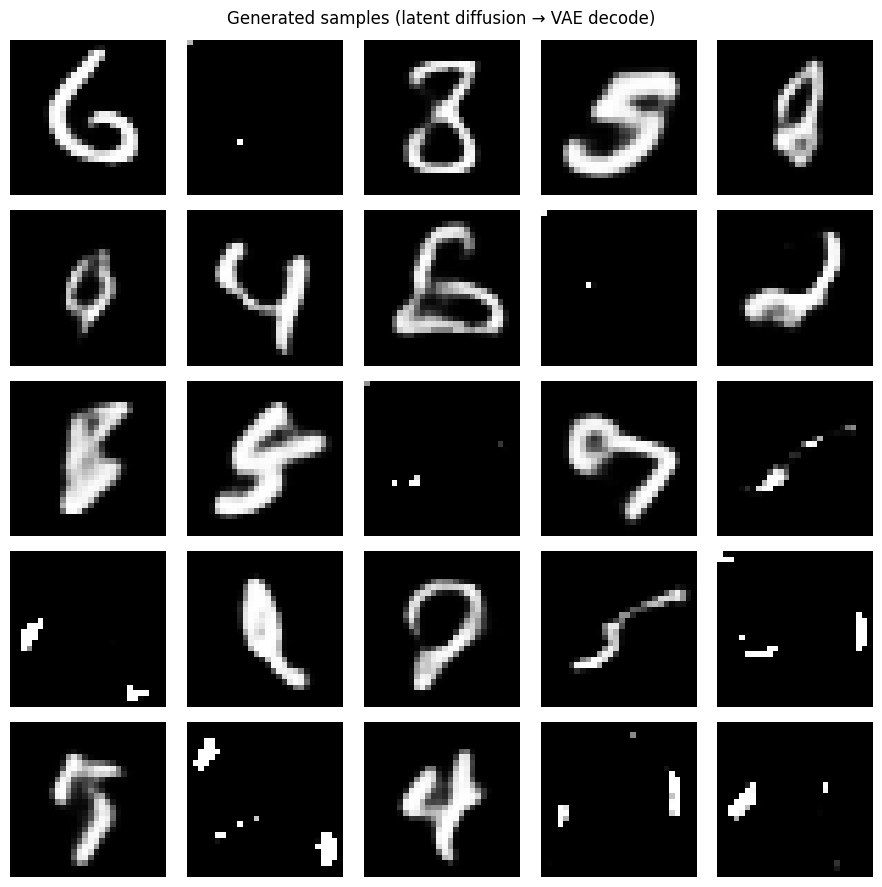

In [ ]:
generate_images_from_diffusion(ddpm, model, latent_ds, device, n=25)


In [ ]:
plot_latent_scatter_2d(latent_ds, ddpm=ddpm)
plot_latent_grid_decode_2d(model, latent_ds, device)


latent_dim != 2, skipping scatter.
latent_dim != 2, skipping grid decode.
